In [14]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('/home/jlaura/autocnet_server/notebooks/bundleout_points.csv')

In [3]:
df.columns

Index(['Point', 'Point.1', 'Accepted', 'Rejected', 'Residual', '3-d', '3-d.1',
       '3-d.2', 'Correction', 'Correction.1', 'Correction.2', 'Coordinate',
       'Coordinate.1', 'Coordinate.2'],
      dtype='object')

In [43]:
acc = df.query('Rejected == False')

In [42]:
sort = acc.sort_values(by='Residual')

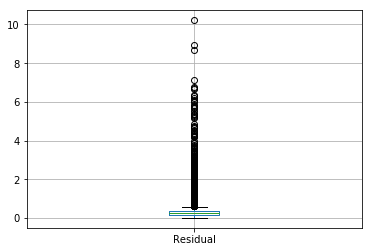

In [17]:
acc.boxplot('Residual')
show()

In [44]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [45]:
geom = [Point(xy) for xy in zip(acc['3-d.1'], acc['3-d'])]

In [46]:
sub = acc[['Point', 'Residual', 'Correction', 'Correction.1', 'Correction.2']]

In [47]:
gdf = GeoDataFrame(sub, crs='+proj=longlat +a=3396190 +b=3376200 +no_defs', geometry=geom)

In [48]:
gdf.head(3)

,Point,Residual,Correction,Correction.1,Correction.2,geometry
0,1,0.64,24.008946,-75.842630,-2.646834,POINT (164.14494521 2.30825349)
1,3,0.33,-7.081299,8.837626,-1.703895,POINT (164.20940708 4.35714227)
2,4,0.27,-7.558411,9.476892,-1.269360,POINT (164.19296755 4.29361882)


In [49]:
from autocnet_server.config import AutoCNet_Config as config

from sqlalchemy.orm import aliased, create_session, scoped_session, sessionmaker
from sqlalchemy import create_engine

sc = config()
db_uri = 'postgresql://{}:{}@{}:{}/{}'.format(sc.database_username,
                                              sc.database_password,
                                              sc.database_host,
                                              sc.database_port,
                                              sc.database_name)
engine = create_engine(db_uri)

In [50]:
from sqlalchemy import Column, String, Integer, Float, ForeignKey, Boolean, LargeBinary
from geoalchemy2 import Geometry, WKTElement


In [51]:
gdf['geom'] = gdf['geometry'].apply(lambda x: WKTElement(x.wkt, srid=949900))
sub = gdf[['Point', 'Residual', 'Correction', 'Correction.1', 'Correction.2', 'geom']]

In [52]:
sub.head(3)

,Point,Residual,Correction,Correction.1,Correction.2,geom
0,1,0.64,24.008946,-75.842630,-2.646834,POINT (164.14494521 2.30825349)
1,3,0.33,-7.081299,8.837626,-1.703895,POINT (164.20940708 4.35714227)
2,4,0.27,-7.558411,9.476892,-1.269360,POINT (164.19296755 4.29361882)


In [53]:
sub.to_sql('controlled', engine, if_exists='replace', index=False, dtype={'Point':Integer, 'Residual':Float,
                                                    'Correction': Float, 'Correction.1': Float, 'Correction.2': Float,
                                                   'geom':Geometry('POINT', srid=949900)})

In [54]:
sub['Residual'].describe()

count    22127.000000
mean         0.298581
std          0.338518
min          0.000000
25%          0.170000
50%          0.250000
75%          0.340000
max         10.220000
Name: Residual, dtype: float64